# Day 08. Exercise 03
# Overfitting

## 0. Imports

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

## 1. Preprocessing

1. Read the file `dayofweek.csv` to a dataframe.
2. Using `train_test_split` with parameters `test_size=0.2`, `random_state=21` get `X_train`, `y_train`, `X_test`, `y_test`.
3. Using, for example, `value_counts()` to check if the distribution of classes is similar in train and test.
4. Use the additional parameter `stratify=` and check the distribution again, now it should be more or less similar in both datasets.

In [4]:
df = pd.read_csv('../data/dayofweek.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,numTrials,hour,dayofweek,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,...,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1
0,-0.788667,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.756764,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.724861,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.692958,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.661055,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
X = df.drop(columns=['dayofweek'])
y = df['dayofweek']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [7]:
y_train.value_counts()

dayofweek
3    313
6    287
1    222
5    216
2    125
0    105
4     80
Name: count, dtype: int64

In [8]:
y_test.value_counts()

dayofweek
3    83
6    69
5    55
1    52
0    31
4    24
2    24
Name: count, dtype: int64

распределения отличаются

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [10]:
y_train.value_counts()

dayofweek
3    316
6    285
1    219
5    217
2    119
0    109
4     83
Name: count, dtype: int64

In [11]:
y_test.value_counts()

dayofweek
3    80
6    71
1    55
5    54
2    30
0    27
4    21
Name: count, dtype: int64

теперь распределения имеют схожий характер

## 2. Baseline models

1. Train exactly the same baseline models from the previous exercise and calculate the accuracies using the test dataset with stratification.
2. Did all the models show the similar values of the metric? Which one has the largest difference comparing the current exercise and the previous? Put the answer to the markdown cell in the end of the section.

### a. Logreg

In [12]:
log_reg = LogisticRegression(random_state=21, fit_intercept=False)
log_reg.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, random_state=21)

In [13]:
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6331


### b. SVM

In [70]:
svc = SVC(kernel='poly', probability=True, random_state=21)
svc.fit(X_train, y_train)

SVC(kernel='poly', probability=True, random_state=21)

In [71]:
y_pred_svc = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svc)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8462


### c. Decision tree

In [16]:
tree = DecisionTreeClassifier(max_depth=4, random_state=21)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=21)

In [17]:
y_pred_tree = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_tree)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5296


### d. Random forest

In [18]:
forest = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, random_state=21)

In [19]:
y_pred_forest = forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_forest)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9290


RandomForestClassifier

## 3. Crossvalidation

We could play with parameters of the model trying to achive a better accuracy on the test dataset, but it is a bad practice. It leads us again to overfitting. Test dataset is only for checking quality of a final model.

But there is another way of solving the problem – crossvalidation. It does not use test dataset, but creates one more split of train dataset. Again, there are different ways of doing it, but the common thing is that there is a validation dataset that is used for hyperparameters optimization.

1. Using `cross_val_score` with `cv=10` calculate the mean accuracy and standard deviation for every model that you used before (logreg with `solver='liblinear'`, SVC, decision tree, random forest).

### a. Logreg

In [104]:
log_reg = LogisticRegression(random_state=21, fit_intercept=False, solver='liblinear')
scores = cross_val_score(log_reg, X_train, y_train, cv=10, scoring='accuracy')
mean_accuracy = np.mean(scores)
std_deviation = np.std(scores)
print(f"Mean Accuracy = {mean_accuracy:.4f}, Standard Deviation = {std_deviation:.4f}")

Mean Accuracy = 0.5816, Standard Deviation = 0.0253


### b. SVM

In [72]:
scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy')
mean_accuracy = np.mean(scores)
std_deviation = np.std(scores)
print(f"Mean Accuracy = {mean_accuracy:.4f}, Standard Deviation = {std_deviation:.4f}")

Mean Accuracy = 0.7982, Standard Deviation = 0.0301


### c. Decision tree

In [22]:
scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')
mean_accuracy = np.mean(scores)
std_deviation = np.std(scores)
print(f"Mean Accuracy = {mean_accuracy:.4f}, Standard Deviation = {std_deviation:.4f}")

Mean Accuracy = 0.5089, Standard Deviation = 0.0319


### d. Random forest

In [23]:
scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')
mean_accuracy = np.mean(scores)
std_deviation = np.std(scores)
print(f"Mean Accuracy = {mean_accuracy:.4f}, Standard Deviation = {std_deviation:.4f}")

Mean Accuracy = 0.9177, Standard Deviation = 0.0216


## 4. Optimization

1. Choose the best model and play a little bit with the parameters on cross-validation, find a good enough parameter or a combination of the parameters.
2. Calculate the accuracy for the final model on the test dataset.
3. Draw a plot that displays the top-10 most  important features for that model.
4. Save the model using `joblib`.
5. Load the model, make predictions for the test dataset and calculate the accuracy.

### Была выбрана модель SVC так как RandomForestClassifier переобучилась на данных.  И в итоге после сохранения выдавала на тестовой выборке accuracy = 0.596

In [49]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': 21,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [95]:
svc = OneVsRestClassifier(SVC(kernel='poly', probability=True, random_state=21))

scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy')

mean_accuracy = np.mean(scores)
std_deviation = np.std(scores)

print(f"Mean Accuracy = {mean_accuracy:.4f}, Standard Deviation = {std_deviation:.4f}")

Mean Accuracy = 0.8071, Standard Deviation = 0.0308


In [96]:
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8728


In [101]:
feature_names = X.columns.tolist()

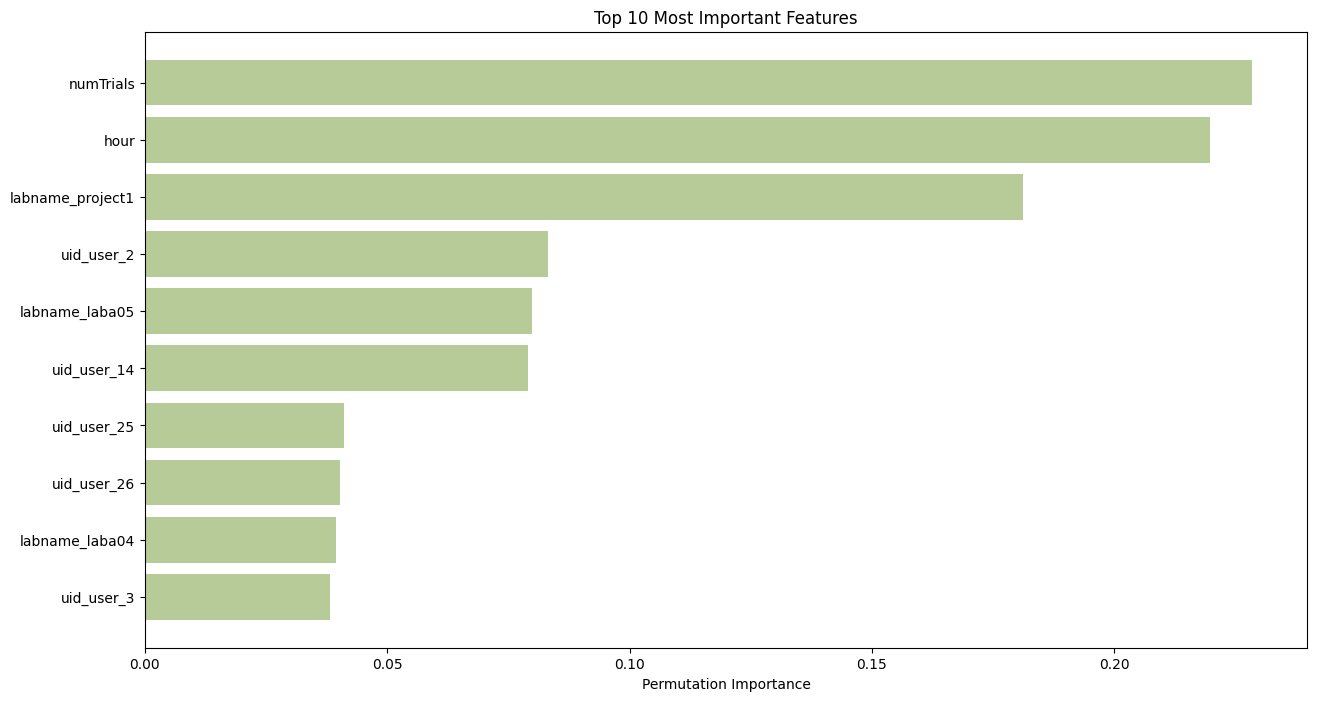

In [107]:
result = permutation_importance(svc, X_test, y_test, n_repeats=10, random_state=42)

importance = result.importances_mean
indices = np.argsort(importance)[-10:]  

plt.figure(figsize=(15, 8))
plt.title("Top 10 Most Important Features")
plt.barh(range(len(indices)), importance[indices], align='center', color='#B7CB99')
plt.yticks(range(len(indices)), np.array(feature_names)[indices])
plt.xlabel("Permutation Importance")
plt.show()

In [108]:
joblib.dump(svc, '../data/best_svc.pkl')

['../data/best_svc.pkl']

In [109]:
model_svc = joblib.load('../data/best_svc.pkl')

In [110]:
y_predict = model_svc.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8728
